In [129]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [130]:
# read data
train_path = 'rsna-2024-lumbar-spine-degenerative-classification/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [131]:
test_desc.head(5)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [132]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [133]:
train_desc.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [134]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, image) for image in images])
    return image_paths    
    
# Generate image paths for train and test data
train_impage_paths = generate_image_paths(train_desc, f'{train_path}train_images')
test_impage_paths = generate_image_paths(test_desc, f'{train_path}test_images')

In [135]:
len(train_desc)

6294

In [136]:
len(train_impage_paths)

147218

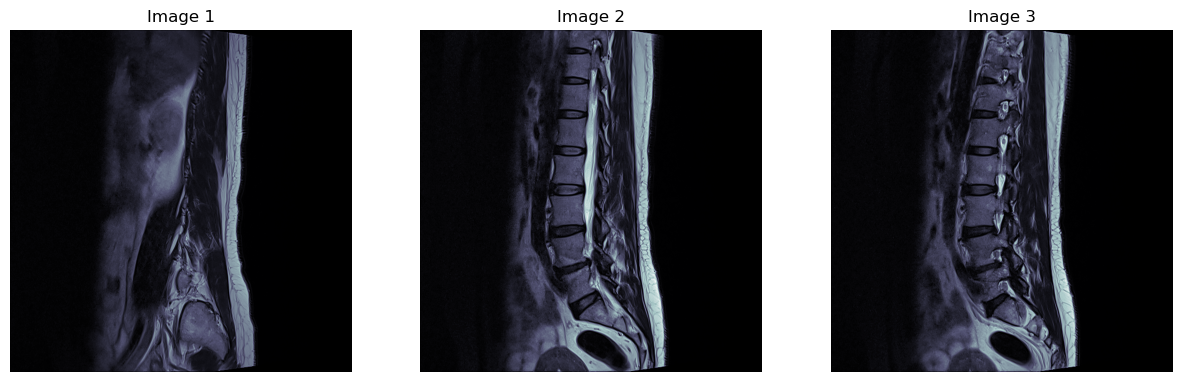

In [208]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f'Image {i+1}')
        plt.axis('off')
    plt.show()
    
# Display first 3 images from train data
display_dicom_images(train_impage_paths)    

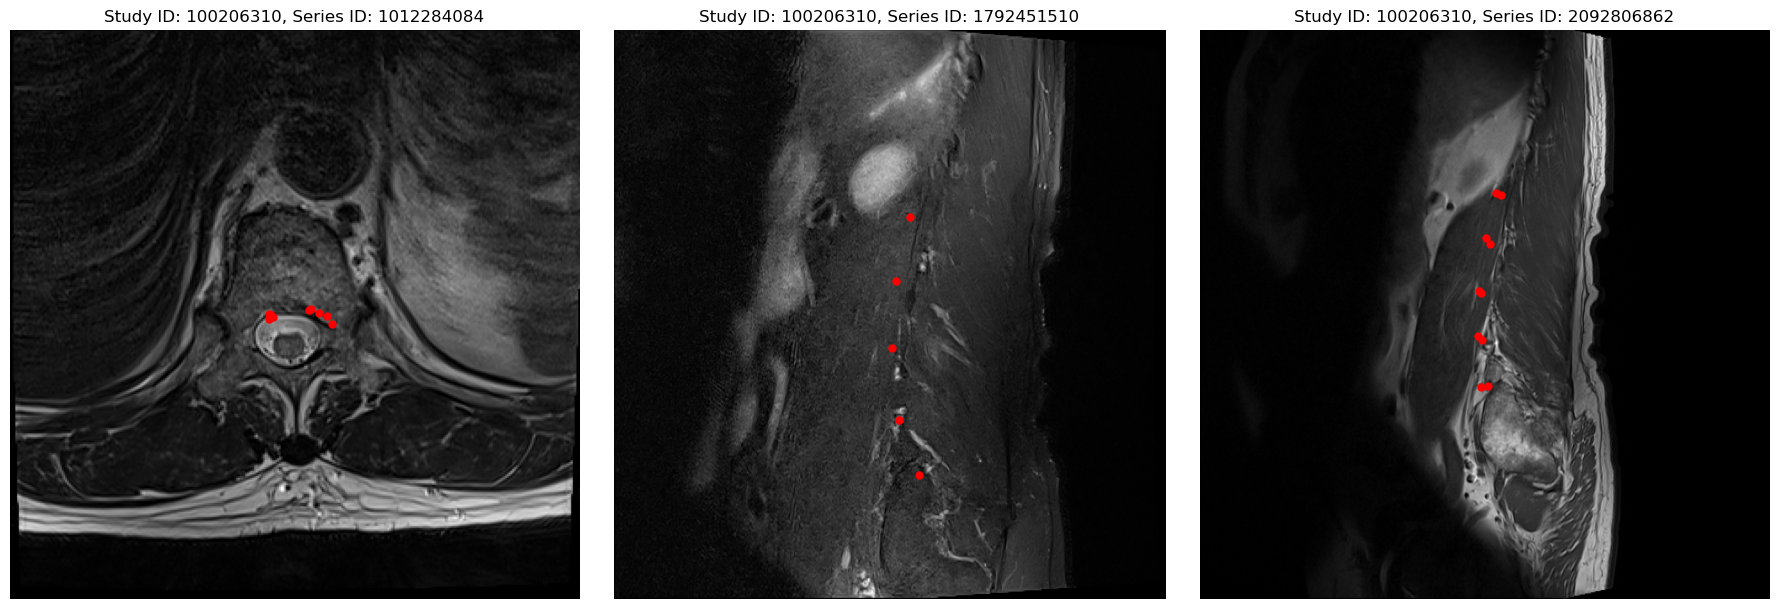

In [138]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):
        study_id = int(path.split('/')[-3])
        series_id = int(path.split('/')[-2])
        
        # Filter label coordinated for the current study and series
        filtered_labels = label_df[(label_df["study_id"] == study_id) & (label_df["series_id"] == series_id)]
        assert len(filtered_labels) > 0, f"No label coordinates found for Study ID: {study_id}, Series ID: {series_id}"
        
        # Read DICOM image
        assert os.path.isfile(path), f"File not found: {path}"
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot label coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
            
    plt.tight_layout()
    plt.show()
        
# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
study_folder = f'{train_path}train_images/{study_id}'    

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])
        
display_dicom_with_coordinates(image_paths, label)        

In [139]:
def reshape_row(row):
    data = {
        'study_id': [],
        'condition': [],
        'level': [],
        'severity': [],
    }
    
    for column, value in row.items():
        if column not in ['study_id', 'condition', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join(word.capitalize() for word in parts[:-2])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows on the reshaped dataframe
new_train_df.head(10)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild


In [140]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [141]:
# Merge the dataframe on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')

# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['study_id', 'series_id'], how='inner')

In [142]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['study_id', 'series_id'], how='inner')

# Display the first few rows of the final merged dataframe
final_merged_df.head(10)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,12,191.321555,170.120141,Sagittal T1
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,12,187.878354,217.245081,Sagittal T1
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,11,186.504472,251.592129,Sagittal T1
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,11,197.100569,289.457306,Sagittal T1


In [143]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x', 'y'], ascending=True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2


In [144]:
test = final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")
test

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


Now, we can see what the data represents

Series ID 1012284084 contains 60 images, and how each image maps to each level and condition

In [145]:
print(len(test))

10


In [146]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("condition")

# Display_df
filtered_df


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11436,1013589491,Left Subarticular Stenosis,L1/L2,Normal/Mild,598943280,33,273.186813,256.649197,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11437,1013589491,Left Subarticular Stenosis,L2/L3,Normal/Mild,598943280,26,262.799662,242.799662,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2


In [147]:
# Sort final_merged_df by study_id, series_id, and series_description for studt_id == 1013589491
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


We see that,

Saggital T1 images map to Neural Foraminal Narrowing

Axial T2 images map to Subarticular Stenosis

Saggital T2/STIR map to Canal Stenosis

In [148]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' + 
    final_merged_df['condition'] + '_' + 
    final_merged_df['level']
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}train_images/' +
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,rsna-2024-lumbar-spine-degenerative-classifica...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,rsna-2024-lumbar-spine-degenerative-classifica...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,rsna-2024-lumbar-spine-degenerative-classifica...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,rsna-2024-lumbar-spine-degenerative-classifica...


In [149]:
final_merged_df[final_merged_df['severity'] == 'Normal/Mild'].value_counts().sum()

37626

In [150]:
final_merged_df[final_merged_df['severity'] == 'Moderate'].value_counts().sum()

7950

In [151]:
# Define the base path for test images
base_path = 'rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}        

# Create a listto store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [152]:
final_merged_df.head(1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...


In [153]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [154]:
test_data = expanded_test_desc
train_data = final_merged_df

In [155]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a Study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the function to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[
    (train_data['study_id_exists']) &
    (train_data['series_id_exists']) &
    (train_data['image_exists'])
]

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True


In [157]:
train_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True


In [158]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

# Keep in mind this potential improvement to avoid quantizing the image data and loosing precision
# data = (data - np.min(data)) / (np.max(data) - np.min(data))
# data = data.astype(np.float32)

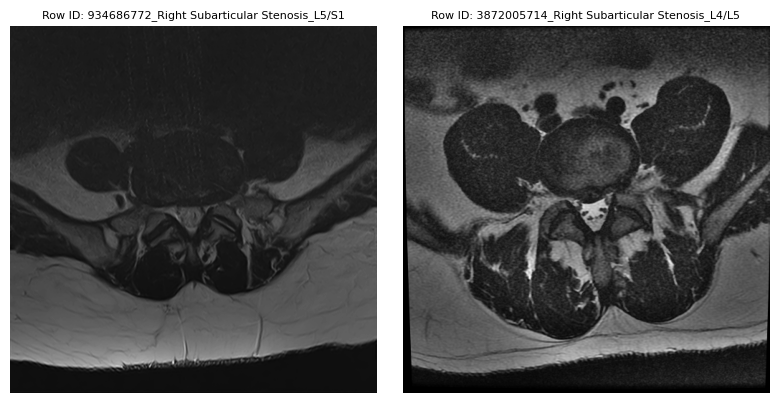

In [160]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')    
fig.tight_layout()
plt.show()

## Loading data

In [161]:
#for one hot encoding
#train_data[['normal_mild', 'severe', 'moderate']] = train_data[['normal_mild', 'severe', 'moderate']].astype(int)  

In [162]:
train_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_Right Subarticular Stenosis_L1/L2,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_Right Subarticular Stenosis_L2/L3,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_Right Subarticular Stenosis_L3/L4,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_Right Subarticular Stenosis_L4/L5,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True


In [163]:
train_data = train_data.dropna()

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)
        label = self.dataframe['severity'][index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    
    train_dataset = CustomDataset(train_df, transform=transform)
    val_dataset = CustomDataset(val_df, transform=transform)
    
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)), # convert to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = 
    create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

# Dictionary mapping labels to indices
label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}


Visualizing Sagittal T1 samples:


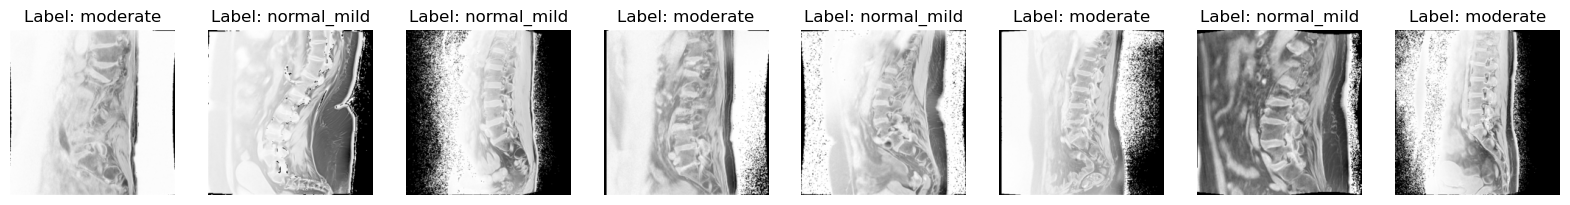

Visualizing Axial T2 samples:


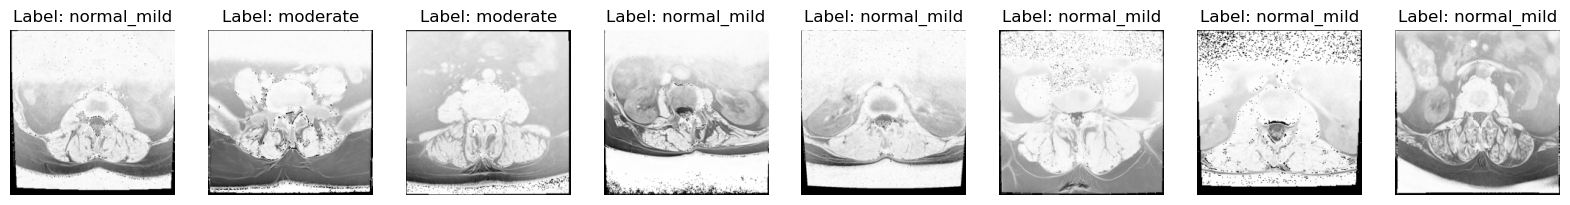

Visualizing Sagittal T2/STIR samples:


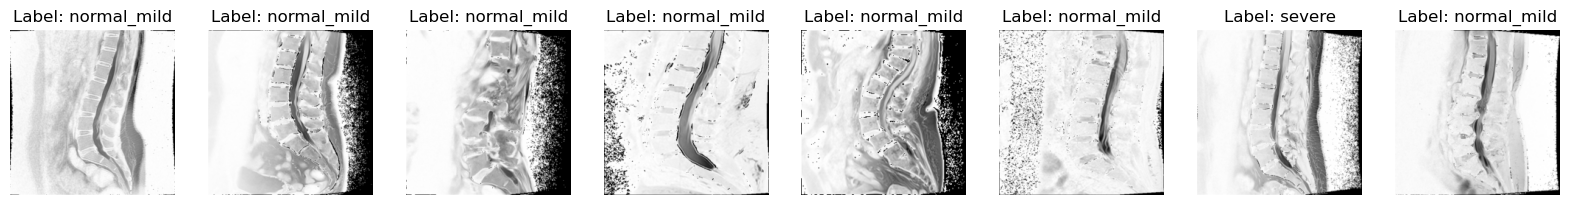

In [165]:
import matplotlib.pyplot as plt

# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0) # Convert to HWC for visualization
        ax.imshow(img)
        ax.set_title(f'Label: {lbl}')
        ax.axis('off')
    plt.show()
    
# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples:")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples:")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples:")
visualize_batch(trainloader_t2stir)
        

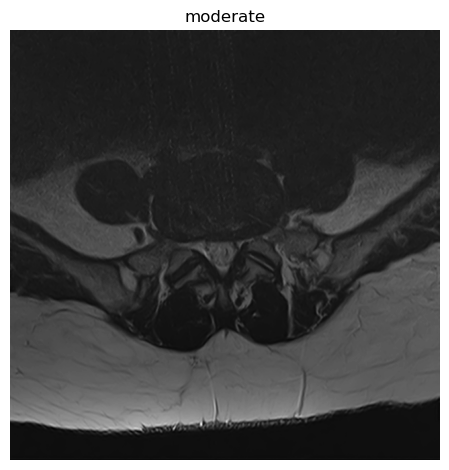

In [167]:
import matplotlib.pyplot as plt

image, label = next(iter(trainloader_t2))
sample = image[1].permute(1, 2, 0)  #sample

# Plot images
plt.figsize=(8, 4)
plt.imshow(images[0], cmap='gray')
plt.title(label[0])
plt.axis('off')
plt.tight_layout()
plt.show()

# Model

ConvNext

In [168]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")    

Using device: cuda


In [176]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze the last 20 layers, keeping BatchNorm layers frozen
        for layer in list(self.model.features.children())[-20:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
        
        # Unfreeze the classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Path to the locally uploaded weights file
weights_path = 'models/efficientnet_v2_s-dd5fe13b.pth'

# Initialize models
sagittal_t1_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
axial_t2_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

# Optionally freeze initial layers
for param in sagittal_t1_model.model.features.parameters():
    param.requires_grad = False
for param in axial_t2_model.model.features.parameters():
    param.requires_grad = False
for param in sagittal_t2stir_model.model.features.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in sagittal_t1_model.model.classifier.parameters():
    param.requires_grad = True
for param in axial_t2_model.model.classifier.parameters():
    param.requires_grad = True
for param in sagittal_t2stir_model.model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Initialize seperate optimizers for each model
optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.parameters(), lr=0.001)

# Store the models and optimizers in dictionaries for easy access
models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir
}

In [177]:
# Count of trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 3843


In [178]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

In [179]:
for images, labels in trainloader_t2:
    labels = torch.tensor([label_map[label] for label in labels])
    labels = labels.to(device)
    print(labels)
    break

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


In [185]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch = epoch + 1)
                
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1).squeeze(0)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
                    
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the best model and check for early stopping
        if(val_acc > best_val_acc):
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f"best_model_{epoch + 1}.pth")
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
            
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_acc
        

In [186]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
    
    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 493/493 [01:37<00:00,  5.04batch/s, epoch=1]


Epoch 1/10, Train Loss: 0.6496, Train Acc: 76.88%, Val Loss: 0.6360, Val Acc: 76.95%


100%|██████████| 493/493 [01:32<00:00,  5.32batch/s, epoch=2]


Epoch 2/10, Train Loss: 0.6466, Train Acc: 76.64%, Val Loss: 0.6310, Val Acc: 78.12%


100%|██████████| 493/493 [01:31<00:00,  5.41batch/s, epoch=3]


Epoch 3/10, Train Loss: 0.6231, Train Acc: 77.37%, Val Loss: 0.6218, Val Acc: 77.94%


100%|██████████| 493/493 [01:31<00:00,  5.37batch/s, epoch=4]


Epoch 4/10, Train Loss: 0.6200, Train Acc: 77.63%, Val Loss: 0.6190, Val Acc: 77.84%


100%|██████████| 493/493 [01:31<00:00,  5.39batch/s, epoch=5]


Epoch 5/10, Train Loss: 0.6188, Train Acc: 77.68%, Val Loss: 0.6187, Val Acc: 77.94%
Early stopping triggered after 5 epochs.
Training model for Axial T2


100%|██████████| 481/481 [01:39<00:00,  4.82batch/s, epoch=1]


Epoch 1/10, Train Loss: 0.7448, Train Acc: 70.39%, Val Loss: 0.7110, Val Acc: 69.24%


100%|██████████| 481/481 [01:25<00:00,  5.63batch/s, epoch=2]


Epoch 2/10, Train Loss: 0.7249, Train Acc: 71.19%, Val Loss: 0.6982, Val Acc: 70.99%


100%|██████████| 481/481 [01:23<00:00,  5.79batch/s, epoch=3]


Epoch 3/10, Train Loss: 0.7045, Train Acc: 71.34%, Val Loss: 0.6851, Val Acc: 71.22%


100%|██████████| 481/481 [01:23<00:00,  5.77batch/s, epoch=4]


Epoch 4/10, Train Loss: 0.7039, Train Acc: 71.01%, Val Loss: 0.6761, Val Acc: 71.61%


100%|██████████| 481/481 [01:24<00:00,  5.69batch/s, epoch=5]


Epoch 5/10, Train Loss: 0.6928, Train Acc: 71.78%, Val Loss: 0.6789, Val Acc: 71.79%


100%|██████████| 481/481 [01:27<00:00,  5.50batch/s, epoch=6]


Epoch 6/10, Train Loss: 0.6982, Train Acc: 71.60%, Val Loss: 0.6688, Val Acc: 71.90%


100%|██████████| 481/481 [01:25<00:00,  5.60batch/s, epoch=7]


Epoch 7/10, Train Loss: 0.6917, Train Acc: 71.65%, Val Loss: 0.6710, Val Acc: 71.77%


100%|██████████| 481/481 [01:24<00:00,  5.72batch/s, epoch=8]


Epoch 8/10, Train Loss: 0.6926, Train Acc: 71.75%, Val Loss: 0.6950, Val Acc: 71.32%


100%|██████████| 481/481 [01:25<00:00,  5.64batch/s, epoch=9]


Epoch 9/10, Train Loss: 0.6866, Train Acc: 71.81%, Val Loss: 0.6757, Val Acc: 71.79%
Early stopping triggered after 9 epochs.
Training model for Sagittal T2/STIR


100%|██████████| 244/244 [00:45<00:00,  5.39batch/s, epoch=1]


Epoch 1/10, Train Loss: 0.4788, Train Acc: 87.33%, Val Loss: 0.4922, Val Acc: 86.00%


100%|██████████| 244/244 [00:43<00:00,  5.56batch/s, epoch=2]


Epoch 2/10, Train Loss: 0.4519, Train Acc: 87.25%, Val Loss: 0.4606, Val Acc: 86.00%


100%|██████████| 244/244 [00:45<00:00,  5.38batch/s, epoch=3]


Epoch 3/10, Train Loss: 0.4393, Train Acc: 87.25%, Val Loss: 0.4534, Val Acc: 86.00%


100%|██████████| 244/244 [00:46<00:00,  5.29batch/s, epoch=4]

Epoch 4/10, Train Loss: 0.4273, Train Acc: 87.60%, Val Loss: 0.4766, Val Acc: 85.54%
Early stopping triggered after 4 epochs.


# Inference

In [187]:
train_data['level'].unique()

array(['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1'], dtype=object)

In [188]:
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [189]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

# Function to update row_id with levels
def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f'{row["study_id"]}_{row["condition"]}_{level}'

# Updaterow_id in expanded_test_desc to include levels
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

# investigate this more!

In [190]:
expanded_test_desc.head(2)


,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,rsna-2024-lumbar-spine-degenerative-classifica...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l2_l3


In [191]:
# Define a custom test dataset class
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        if self.transform:
            image = self.transform(image)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(expanded_test_desc, transform=transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [192]:
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [197]:
# Function to get the model based on series_description
def get_model(series_description):
    return models.get(series_description, None)

# Function to make predictions on the test data
def predict_test_data(testloader, expanded_test_desc):
    predictions = []
    normal_mild_probs = []
    moderate_probs = []
    severe_probs = []
    
    for model in models.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            if model:
                model.eval() # Set the model to eval mode
                outputs = model(images.to(device))
                probs = torch.softmax(outputs, dim=1).squeeze(0)
                normal_mild_probs.append(probs[0].item())
                moderate_probs.append(probs[1].item())
                severe_probs.append(probs[2].item())
                predictions.append(probs)
            else:
                predictions.append(None)
                normal_mild_probs.append(None)
                moderate_probs.append(None)
                severe_probs.append(None)
    
    return normal_mild_probs, moderate_probs, severe_probs, predictions

In [198]:
# Make predictions on the test data
normal_mild_probs, moderate_probs, severe_probs, test_predictions = predict_test_data(testloader, expanded_test_desc)

  0%|          | 0/194 [00:00<?, ?it/s]/root/miniconda3/envs/work/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 194/194 [00:09<00:00, 20.19it/s]


In [199]:
test_predictions[0]

tensor([0.8255, 0.0619, 0.1126], device='cuda:0')

In [200]:
# Add predictions and probabilities to the test DataFrame
expanded_test_desc['normal_mild'] = normal_mild_probs
expanded_test_desc['moderate'] = moderate_probs
expanded_test_desc['severe'] = severe_probs

In [201]:
submission = expanded_test_desc[["row_id","normal_mild","moderate","severe"]]

In [202]:
submission.head(10)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.825515,0.061894,0.112591
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.717898,0.159685,0.122417
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.531602,0.239046,0.229352
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.549283,0.211031,0.239686
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.608422,0.276199,0.115379
5,44036939_left_neural_foraminal_narrowing_l1_l2,0.494417,0.278148,0.227435
6,44036939_left_neural_foraminal_narrowing_l2_l3,0.625683,0.156219,0.218099
7,44036939_left_neural_foraminal_narrowing_l3_l4,0.486551,0.244677,0.268772
8,44036939_left_neural_foraminal_narrowing_l4_l5,0.582453,0.220097,0.197450
9,44036939_left_neural_foraminal_narrowing_l5_s1,0.627204,0.188797,0.183999


In [203]:
# Group by 'row_id' and sum the values
grouped_submission = submission.groupby('row_id').max().reset_index()

# Normalize the columns
#grouped_submission[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']].div(grouped_submission[['normal_mild', 'moderate', 'severe']].sum(axis=1), axis=0)

# Check the first 3 rows
grouped_submission

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.842313,0.278148,0.238537
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.882076,0.202219,0.376306
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.877416,0.244677,0.410285
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.776303,0.222201,0.239686
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.757345,0.276199,0.185486
5,44036939_left_subarticular_stenosis_l1_l2,0.845435,0.389011,0.229809
6,44036939_left_subarticular_stenosis_l2_l3,0.797061,0.332709,0.288260
7,44036939_left_subarticular_stenosis_l3_l4,0.916840,0.324900,0.336702
8,44036939_left_subarticular_stenosis_l4_l5,0.955453,0.373673,0.227461
9,44036939_left_subarticular_stenosis_l5_s1,0.848042,0.381969,0.324034


In [204]:
len(grouped_submission)

25

In [205]:
sub[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']]

In [206]:
import os

# Save the DataFrame to "submission.csv" in the desired directory
sub.to_csv("submission.csv", index=False)

In [207]:
sub.head(5)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.842313,0.278148,0.238537
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.882076,0.202219,0.376306
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.877416,0.244677,0.410285
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.776303,0.222201,0.239686
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.757345,0.276199,0.185486


In [209]:
print(grouped_submission.columns)

Index(['row_id', 'normal_mild', 'moderate', 'severe'], dtype='object')
